In [3]:
# HIDDEN
using CSV
using DataFrames
using MLJ
using Statistics
using StatsPlots
Base.displaysize() = (5, 90)

## Using Logistic Regression

We have developed all the components of logistic regression. First, the logistic model used to predict probabilities:

$$
\begin{aligned}
f_\hat{\boldsymbol{\theta}} (\textbf{x}) = \sigma(\hat{\boldsymbol{\theta}} \cdot \textbf{x})
\end{aligned}
$$

Then, the cross-entropy loss function:

$$
\begin{aligned}
L(\boldsymbol{\theta}, \textbf{X}, \textbf{y}) = &= \frac{1}{n} \sum_i \left(- y_i \ln \sigma_i - (1 - y_i) \ln (1 - \sigma_i ) \right) \\
\end{aligned}
$$

Finally, the gradient of the cross-entropy loss for gradient descent:

$$
\begin{aligned}
\nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta}, \textbf{X}, \textbf{y})
&= - \frac{1}{n} \sum_i \left(
    y_i - \sigma_i
\right) \textbf{X}_i \\
\end{aligned}
$$

In the expressions above, we let $ \textbf{X} $ represent the $ n \times p $ input data matrix, $\textbf{x}$ a row of $ \textbf{X} $, $ \textbf{y} $ the vector of observed data values, and $ f_\hat{\boldsymbol{\theta}}(\textbf{x}) $ the logistic model with optimal parameters $\hat{\boldsymbol{\theta}}$ . As a shorthand, we define $ \sigma_i = f_\hat{\boldsymbol{\theta}}(\textbf{X}_i) = \sigma(\textbf{X}_i \cdot \hat{\boldsymbol{\theta}}) $.

## Logistic Regression on LeBron's Shots

Let us now return to the problem we faced at the start of this chapter: predicting which shots LeBron James will make. We start by loading the dataset of shots taken by LeBron in the 2017 NBA Playoffs.

In [4]:
lebron = CSV.read("lebron.csv")

,game_date,minute,opponent,action_type,shot_type,shot_distance,shot_made
,Int64,Int64,String,String,String,Int64,Int64
1,20170415,10,IND,Driving Layup Shot,2PT Field Goal,0,0
2,20170415,11,IND,Driving Layup Shot,2PT Field Goal,0,1
3,20170415,14,IND,Layup Shot,2PT Field Goal,0,1
4,20170415,15,IND,Driving Layup Shot,2PT Field Goal,0,1
5,20170415,18,IND,Alley Oop Dunk Shot,2PT Field Goal,0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


We start by using only the shot distance to predict whether or not the shot is made. The package `ScikitLearn` conveniently provides a logistic regression classifier `LogisticClassifier`. Another similar model is provided by [`MLJLinearModels`](https://github.com/alan-turing-institute/MLJLinearModels.jl).


We first obtain our data matrix `X` and vector of observed outcomes `y` by using `unpack`:

In [21]:
y, X = unpack(select(lebron, [:shot_distance, :shot_made]), ==(:shot_made), colname -> true;
    :shot_distance=>Continuous, :shot_made=>Multiclass);

X = DataFrame(shot_distance=X)

,shot_distance
,Float64
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
⋮,⋮


As is customary, we split our data into a training set and a test set.

In [12]:
train, test = partition(eachindex(y), 0.9, shuffle=true)
println("Training set size: ", length(train))
println("    Test set size: ", length(test))

Training set size: 346
    Test set size: 38


Following `MLJ`'s [workflow](https://alan-turing-institute.github.io/MLJ.jl/stable/common_mlj_workflows/), we load the model, create a `machine` object along with our training dataset, and use `fit!`:

In [67]:
simple_clf = @load LogisticClassifier pkg=ScikitLearn

clf = machine(simple_clf, X, y)
fit!(clf, rows=train, verbosity=0)

# We can see the details of our model:
simple_clf

┌ Info: A model type "LogisticClassifier" is already loaded. 
│ No new code loaded. 
└ @ MLJModels /Users/irinabchan/.julia/packages/MLJModels/Ra3QV/src/loading.jl:43


LogisticClassifier(penalty = "l2",
                   dual = false,
                   tol = 0.0001,
                   C = 1.0,
                   fit_intercept = true,
                   intercept_scaling = 1.0,
                   class_weight = nothing,
                   random_state = nothing,
                   solver = "lbfgs",
                   max_iter = 100,
                   multi_class = "auto",
                   verbose = 0,
                   warm_start = false,
                   n_jobs = nothing,
                   l1_ratio = nothing,) @ 1…98

To visualize the classifier's performance, we plot the original points and the classifier's predicted probabilities.

In [28]:
# HIDDEN
using Random
Random.seed!(42)

function jitter_df(df, x_col, y_col)
    x_jittered = df[:, x_col] .+ randn(length(df[:, x_col])) .* 0
    y_jittered = df[:, y_col] .+ randn(length(df[: ,y_col])) .* 0.05
    return DataFrame(x_col=x_jittered, y_col=y_jittered)
end;

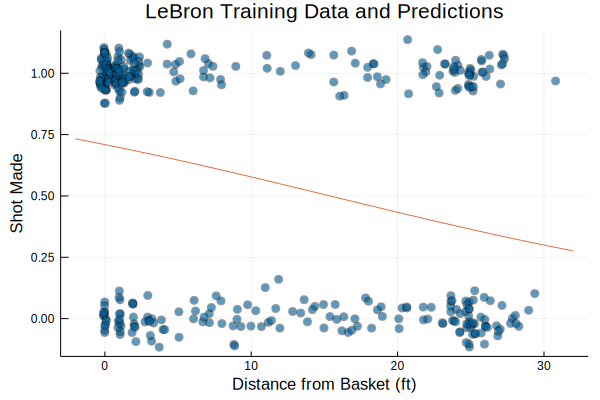

In [68]:
# HIDDEN
lebron_jittered = jitter_df(lebron, :shot_distance, :shot_made)
@df lebron_jittered dotplot(:x_col, :y_col, markeralpha=0.4, legend=false)

xs = collect(range(-2, 32, length=100))
prob_predictions = predict(clf, DataFrame(x1=xs))
ys = pdf.(prob_predictions, 1)

plot!(xs, ys)

title!("LeBron Training Data and Predictions")
xlabel!("Distance from Basket (ft)")
ylabel!("Shot Made")

## Evaluating the Classifier

One method to evaluate the effectiveness of our classifier is to check its prediction accuracy: what proportion of points does it predict correctly?

In [71]:
score = evaluate!(clf, verbosity=0);
println(score.measurement)

[0.6431492591451348]


Our classifier achieves a rather low accuracy of 0.64 on the test set. If our classifier simply guessed each point at random, we would expect an accuracy of 0.50. In fact, if our classifier simply predicted that every shot LeBron takes will go in, we would also get an accuracy of around 0.60:

In [82]:
# Calculates the accuracy if we always predict 1
count(y[test] .== 1)/length(test)

0.5789473684210527

For this classifier, we only used one out of several possible features. As in multivariable linear regression, we will likely achieve a more accurate classifier by incorporating more features.

## Multivariable Logistic Regression

Incorporating more numerical features in our classifier is as simple as extracting additional columns from the `lebron` DataFrame into the `X` DataFrame. Incorporating categorical features, on the other hand, requires us to apply a one-hot encoding. In the code below, we augment our classifier with the `minute`, `opponent`, `action_type`, and `shot_type` features, using `Flux`'s [`One-Hot Encoding`](https://fluxml.ai/Flux.jl/stable/data/onehot/) functions to apply a one-hot encoding to the categorical variables.

In [99]:
using Flux

categorical_columns = ["shot_distance", "minute", "action_type", "shot_type", "opponent"]
cat_df = DataFrame()
for column in categorical_columns
    labels = unique(lebron[:, Symbol(column)])
    categorical_one_hot_matrix = Flux.onehotbatch(lebron[:, Symbol(column)], labels)
    temp_df = DataFrame(transpose(categorical_one_hot_matrix), [Symbol(column*"="*string(i)) for i in labels])
    cat_df = hcat(cat_df, temp_df)
end 
size(cat_df)

(384, 119)

We will again split the data into a training set and test set:

In [115]:
lebron_one_hot_encoded_df = hcat(cat_df, select(lebron, :shot_made))
y, X = unpack(lebron_one_hot_encoded_df, ==(:shot_made), colname -> true;
    :shot_made=>Multiclass)

train, test = partition(eachindex(y), 0.9, shuffle=true)
println("Training set size: ", length(train))
println("    Test set size: ", length(test))

Training set size: 346
    Test set size: 38


Finally, we fit our model once more and check its accuracy:

In [120]:
clf_cat = machine(simple_clf, X, y)
fit!(clf_cat, rows=train, verbosity=0)

score_cat = evaluate!(clf_cat, verbosity=0);
println(score_cat.measurement)

┌ Warning: The scitype of `X`, in `machine(model, X, y)` or `machine(model, X, y, w)` is incompatible with `model`:
│ scitype(X) = ScientificTypes.Table{AbstractArray{Count,1}}
│ input_scitype(model) = ScientificTypes.Table{#s13} where #s13<:(AbstractArray{#s12,1} where #s12<:Continuous). 
└ @ MLJBase /Users/irinabchan/.julia/packages/MLJBase/sMgCp/src/machines.jl:54


[0.6721571527333997]


This classifier is around 3% more accurate than the classifier that only took the shot distance into account. In Section 17.7, we explore additional metrics used to evaluate classifier performance.

## Summary

We have developed the mathematical and computational machinery needed to use logistic regression for classification. Logistic regression is widely used for its simplicity and effectiveness in prediction.